In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from matplotlib.pyplot import legend, title
from scipy.special import y0_zeros

sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [2]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
emeApi = lumapi.MODE()

Units

In [3]:
um = 1e-6
nm = 1e-9

Device parameters

In [24]:
#inverse tapers
taper_length      = 300*um
taper_larger_tip  = 0.55*um
taper_smaller_tip = 0.1*um
taper_tip_sweep = np.linspace(0, 0.55*um,10)

#wire waveguide
wg_length = 100*um
wg_width  = 0.55*um

#general
height = 0.34*um

Materials

In [5]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [6]:
emeApi.switchtolayout()
emeApi.deleteall()
emeApi.cleardcard

<bound method Lumerical.__init__.<locals>.<lambda>.<locals>.<lambda> of <lumapi.MODE object at 0x0000020543BA6810>>

Taper

 $z′ = \frac{(z−z0)}{(z1−z0)}$
 
$f(z') = z'$

Where z0 is the starting point and z1 is the ending point


In [25]:
x0 = 0
x1 = taper_length
y1 = taper_larger_tip/2
y0 = taper_smaller_tip/2
x = np.linspace(x0,x1,21)
alpha = (x-x0)/(x1-x0)
#alpha = (np.exp((x-x0)/(x1-x0))-1)/(np.exp(1)-1)
equation = y0 + alpha * (y1-y0)
upper = np.column_stack((x,equation))
lower = np.column_stack((x[::-1], -equation[::-1]))
taper = np.vstack((upper, lower))

In [8]:
emeApi.addpoly()

In [27]:
emeApi.set('name', 'taper')
emeApi.set('vertices', taper)   
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

referencia: 2*exp(--0.1386294361119891*x)
meu: 

Wire waveguide

In [10]:
emeApi.addrect()
emeApi.set('name', 'wire waveguide')
emeApi.set('x', taper_length + wg_length/2)
emeApi.set('x span', wg_length)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

PECVD

In [11]:
emeApi.addrect()
emeApi.set('name', 'buried oxide layer')
emeApi.set('x', (taper_length+wg_length)/2)
emeApi.set('x span', wg_length + taper_length)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z', -(1*um))
emeApi.set('z span', 2*um)
emeApi.set('material', materialClad)

Analysis    

In [12]:
emeApi.addfde()

In [21]:
emeApi.switchtolayout()
emeApi.set('solver type', '2D X normal')
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('y span', wg_width*6)
emeApi.set('z', (height-2*um)/2)
emeApi.set('z span', (height + 2*um)*6) 
emeApi.set('background material', materialClad)

In [22]:
neff_TE_mode = []
neff_TM_mode = []
#TE
for i in range(len(taper_tip_sweep)):
    emeApi.switchtolayout()
    emeApi.select('taper')
    y0 = taper_tip_sweep[i]/2
    equation = y0 + alpha * (y1-y0)
    upper = np.column_stack((x,equation))
    lower = np.column_stack((x[::-1], -equation[::-1]))
    taper = np.vstack((upper, lower))
    emeApi.set('vertices', taper)
    emeApi.run()
    emeApi.findmodes()
    neff_TE_mode.append(emeApi.real(emeApi.getdata('mode1', 'neff')))
    neff_TM_mode.append(emeApi.real(emeApi.getdata('mode2', 'neff')))

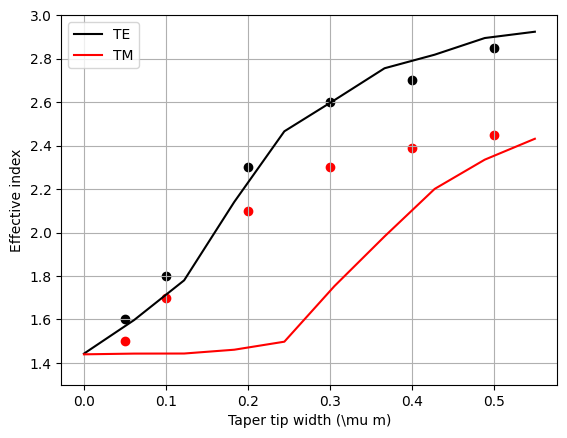

In [23]:
plt.scatter(x=[0.05,0.1,0.2,0.3,0.4,0.5], y=[1.5,1.7,2.1,2.3,2.39,2.45], color='red')
plt.scatter(x=[0.05,0.1,0.2,0.3,0.4,0.5], y=[1.6,1.8,2.3,2.6,2.7,2.85], color='black')
plt.plot(taper_tip_sweep/um,neff_TE_mode, color='black', label='TE') 
plt.plot(taper_tip_sweep/um,neff_TM_mode, color='red', label='TM')
plt.xlabel('Taper tip width (\mu m)')
plt.ylabel('Effective index')
plt.ylim(1.3,3)
plt.grid()
plt.legend()

In [16]:
neff_interpol = interpolate.interp1d(taper_tip_sweep, neff_TE_mode)
neff_interpolSmooth = interpolate.UnivariateSpline(taper_tip_sweep, neff_TE_mode)
neff_interpolSmooth.set_smoothing_factor(500)

neff_interpol2 = interpolate.interp1d(taper_tip_sweep, neff_TM_mode)
neff_interpolSmooth = interpolate.UnivariateSpline(taper_tip_sweep, neff_TM_mode)
neff_interpolSmooth.set_smoothing_factor(500)

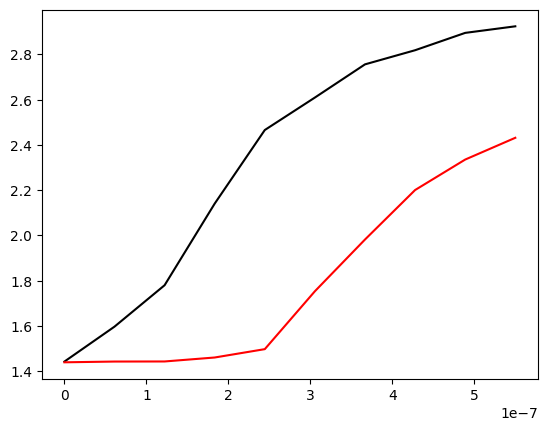

In [17]:
plt.plot(taper_tip_sweep, neff_interpol(taper_tip_sweep), color='black', label='TE')
plt.plot(taper_tip_sweep, neff_interpol2(taper_tip_sweep), color='red', label='TM')
plt.show()